# Estimación del MIC con métodos de clasificación ordinal

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder

from ordinal_class import OrdinalClassifier
from camda_functions import get_X_y_ordinal, split_stratified_into_train_val_test, search_params_ordinal, ordinal_clas_stat2, results_report

Pipeline con datos seleccionados (AMR count)
- Selección de características con RF o RFE
- Encoding TF-IDF
- Baseline: regresión lineal múltiple y RF para clasificacion o regresion
- Clasificadores ordinales basados en los siguientes clasificadores base:
    - Regresión Logística
    - CART
    - Random Forests
    - Neural Networks con recodificación ordinal de $y$
- Comparación de resultados

## Meropenem Loose

In [3]:
os.getcwd()

'/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/Notebooks'

### Variables $(\mathbf{X}, \mathbf{y})$

- Se obtiene la variable independiente $X$ según el pipeline (TF-IDF -> LSA/NMF) para train y test
- Se obtiene la variable dependiente $y$ para train y test, con el MIC recategorizado según ciertos bins. Se convierte a una variable categórica tipo string y también, se codifica como una variable int mediante un label encoder (le), que también se devuelve
- Adicinoalmente, se devuelven los metadatos para train y test, que contienen los valores originales del MIC

In [38]:
ruta_data = '/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/DataSets/'
# ['CiprofloxacinLoose', 'CiprofloxacinStrict', 'MeropenemLoose', 'MeropenemStriect']
data_label = 'MeropenemLoose'
X_nombre_archivo = 'Resistance' + data_label + '.tsv.gz' 
Y_nombre_archivo = "MIC_categorizado"

ruta_fact = '/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/Notebooks/' # si hay alguna factorización guardada...
n_comp = 100 #cuántos componentes?

metadata, metadata_tr, metadata_te, amr_count_train, amr_count_test, y, y_cat, le = \
    get_X_y_ordinal(ruta_data, X_nombre_archivo, Y_nombre_archivo, data_label, only_counts =True)

In [39]:
from camda_functions import rf_features, rfe_features, get_reduced_df

num_feat = 100
sel_vars_rf = rf_features(amr_count_train, y_cat, num_features=num_feat)

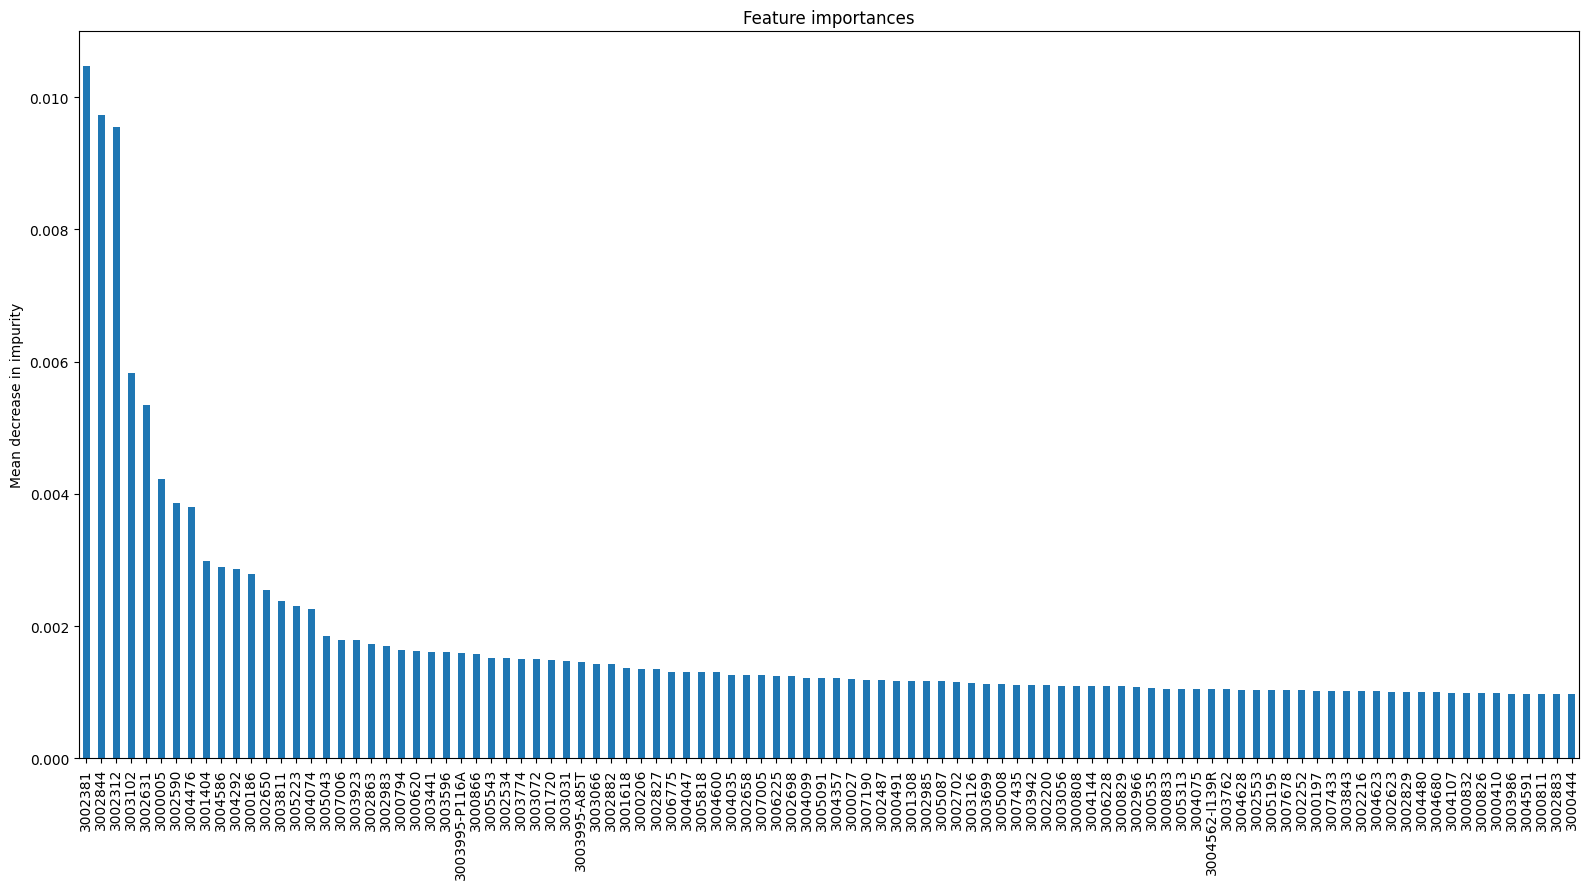

In [4]:
fig, ax = plt.subplots(figsize=(16,9))
sel_vars_rf.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [5]:
sel_vars_rfe = rfe_features(amr_count_train, y_cat, num_features=num_feat, steps=50)

In [40]:
amr_count_train_reduced_rf = get_reduced_df(amr_count_train, amr_count_train.columns.tolist(), sel_vars_rf)
amr_count_train_reduced_rfe = get_reduced_df(amr_count_train, amr_count_train.columns.tolist(), sel_vars_rfe)

In [7]:
amr_count_train_reduced_rf

,3000535,3005091,3000833,3007433,3005008,3000620,3002985,3000829,3003843,3003699,...,3005313,3003126,3002252,3001618,3002312,3002200,3005223,3004562-I139R,3003995-A85T,3003995-P116A
accession,,,,,,,,,,,,,,,,,,,,,
GCA_002947415,20.0,7.0,19.0,16.0,6.0,33.0,14.0,7.0,5.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
GCA_002947845,18.0,7.0,18.0,16.0,6.0,35.0,14.0,6.0,6.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
GCA_002948925,19.0,6.0,15.0,14.0,5.0,33.0,11.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GCA_002996805,18.0,7.0,19.0,15.0,4.0,35.0,12.0,10.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
GCA_003006035,20.0,8.0,17.0,16.0,7.0,38.0,13.0,5.0,7.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5122327,44.0,20.0,34.0,30.0,26.0,67.0,20.0,30.0,19.0,11.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
SRR5122329,42.0,23.0,34.0,28.0,26.0,69.0,22.0,30.0,21.0,9.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
SRR5122330,47.0,24.0,34.0,30.0,24.0,72.0,18.0,27.0,22.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [8]:
amr_count_train_reduced_rfe

,3002623,3003109,3002482,3003962,3004559,3002988,3002663,3000807,3007442,3003811,...,3005866,3005543,3007243,3001170,3002312,3002200,3004356,3001619,3003995-A85T,3003995-P116A
accession,,,,,,,,,,,,,,,,,,,,,
GCA_002947415,0.0,5.0,0.0,2.0,1.0,0.0,1.0,3.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_002947845,4.0,5.0,0.0,2.0,0.0,0.0,1.0,6.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_002948925,1.0,7.0,0.0,2.0,0.0,0.0,1.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_002996805,2.0,5.0,1.0,2.0,1.0,1.0,1.0,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_003006035,0.0,3.0,0.0,4.0,0.0,0.0,1.0,3.0,2.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5122327,1.0,5.0,5.0,8.0,3.0,2.0,3.0,5.0,2.0,3.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SRR5122329,1.0,3.0,4.0,9.0,4.0,3.0,4.0,5.0,3.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR5122330,2.0,2.0,4.0,8.0,3.0,1.0,4.0,4.0,2.0,3.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
from camda_functions import get_tfidf

tfidf_vect_rf, tfidf_rf = get_tfidf(amr_count_train_reduced_rf)
tfidf_rf = pd.DataFrame(tfidf_rf,columns=tfidf_vect_rf.get_feature_names_out(),index=amr_count_train_reduced_rf.index)
tfidf_vect_rfe, tfidf_rfe = get_tfidf(amr_count_train_reduced_rfe)
tfidf_rfe = pd.DataFrame(tfidf_rfe,columns=tfidf_vect_rfe.get_feature_names_out(),index=amr_count_train_reduced_rfe.index)
tfidf_rf

,3000535,3005091,3000833,3007433,3005008,3000620,3002985,3000829,3003843,3003699,...,3005313,3003126,3002252,3001618,3002312,3002200,3005223,3004562-I139R,3003995-A85T,3003995-P116A
accession,,,,,,,,,,,,,,,,,,,,,
GCA_002947415,0.312776,0.109472,0.297232,0.250301,0.093893,0.516080,0.218943,0.109472,0.078269,0.078219,...,0.0,0.000000,0.022858,0.0,0.0,0.000000,0.0,0.031388,0.0,0.0
GCA_002947845,0.286281,0.111332,0.286372,0.254553,0.095488,0.556658,0.222663,0.095427,0.095518,0.079548,...,0.0,0.000000,0.023247,0.0,0.0,0.000000,0.0,0.031921,0.0,0.0
GCA_002948925,0.331237,0.104601,0.261587,0.244147,0.087223,0.575307,0.191769,0.087168,0.087251,0.087196,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.017495,0.0,0.0
GCA_002996805,0.288182,0.112071,0.304290,0.240229,0.064081,0.560355,0.192122,0.160101,0.112178,0.080076,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.032133,0.0,0.0
GCA_003006035,0.305780,0.122312,0.259996,0.244702,0.107091,0.580981,0.198757,0.076445,0.107125,0.122351,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.030685,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5122327,0.345110,0.156868,0.266761,0.235378,0.204059,0.525509,0.156868,0.235302,0.149168,0.086305,...,0.0,0.000000,0.000000,0.0,0.0,0.019413,0.0,0.015742,0.0,0.0
SRR5122329,0.331832,0.181718,0.268712,0.221292,0.205551,0.545153,0.173817,0.237023,0.166075,0.071130,...,0.0,0.011273,0.000000,0.0,0.0,0.000000,0.0,0.015857,0.0,0.0
SRR5122330,0.362754,0.185236,0.262502,0.231619,0.185354,0.555709,0.138927,0.208391,0.169962,0.084927,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.015491,0.0,0.0


In [12]:
tfidf_rfe

,3002623,3003109,3002482,3003962,3004559,3002988,3002663,3000807,3007442,3003811,...,3005866,3005543,3007243,3001170,3002312,3002200,3004356,3001619,3003995-A85T,3003995-P116A
accession,,,,,,,,,,,,,,,,,,,,,
GCA_002947415,0.000000,0.211177,0.000000,0.084552,0.042343,0.000000,0.042737,0.126787,0.088726,0.340805,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GCA_002947845,0.182623,0.221322,0.000000,0.088614,0.000000,0.000000,0.044790,0.265756,0.046494,0.312531,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GCA_002948925,0.048337,0.328047,0.000000,0.093818,0.000000,0.000000,0.047420,0.187575,0.000000,0.189077,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GCA_002996805,0.091485,0.221742,0.046301,0.088782,0.044462,0.048529,0.044875,0.133130,0.000000,0.313124,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GCA_003006035,0.000000,0.141521,0.000000,0.188875,0.000000,0.000000,0.047734,0.141611,0.099100,0.285490,...,0.0,0.000000,0.000000,0.159105,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5122327,0.030028,0.145566,0.151973,0.233128,0.087563,0.063715,0.088376,0.145659,0.061159,0.088095,...,0.0,0.076959,0.034505,0.000000,0.0,0.072013,0.0,0.0,0.0,0.0
SRR5122329,0.030245,0.087970,0.122456,0.264162,0.117593,0.096262,0.118686,0.146710,0.092401,0.059154,...,0.0,0.077514,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
SRR5122330,0.059002,0.057204,0.119444,0.229036,0.086026,0.031298,0.115767,0.114481,0.060086,0.086549,...,0.0,0.075608,0.033900,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### Conteo de los valores MIC

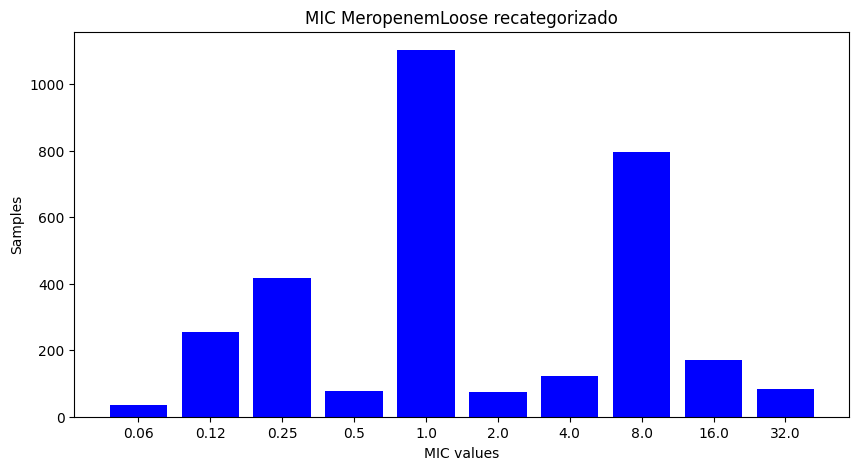

In [4]:
counts_mic = pd.DataFrame(metadata_tr['mic_recat'].value_counts())
counts_mic['mic_values'] = counts_mic.index
counts_mic['str_mic'] = [str(val) for val in counts_mic['mic_values']]
counts_mic = counts_mic.sort_values('mic_values')

plt.figure(figsize=(10,5))
plt.bar(counts_mic['str_mic'], counts_mic['count'], color ='blue', width = 0.8)
plt.title('MIC ' + data_label + ' recategorizado')
plt.xlabel("MIC values")
plt.ylabel("Samples")
plt.show()


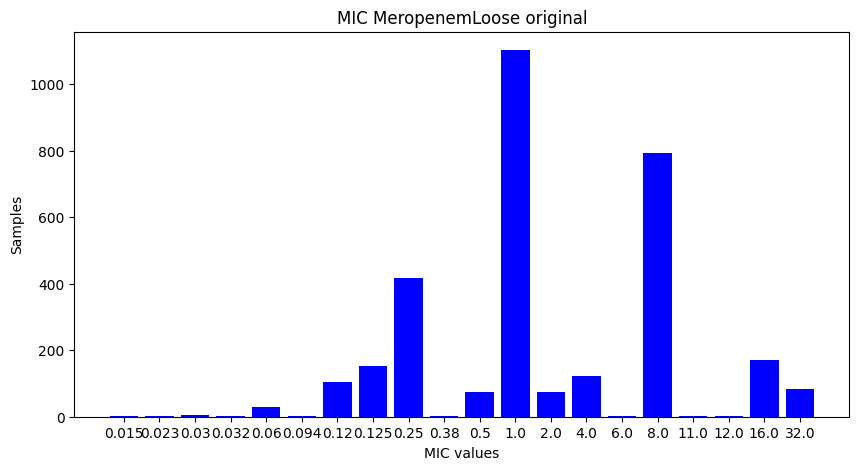

In [5]:
counts_mic = pd.DataFrame(metadata_tr['mic'].value_counts())
counts_mic['mic_values'] = counts_mic.index
counts_mic['str_mic'] = [str(val) for val in counts_mic['mic_values']]
counts_mic = counts_mic.sort_values('mic_values')

plt.figure(figsize=(10,5))
plt.bar(counts_mic['str_mic'], counts_mic['count'], color ='blue', width = 0.8)
plt.title('MIC ' + data_label + ' original')
plt.xlabel("MIC values")
plt.ylabel("Samples")
plt.show()

<Figure size 640x480 with 0 Axes>

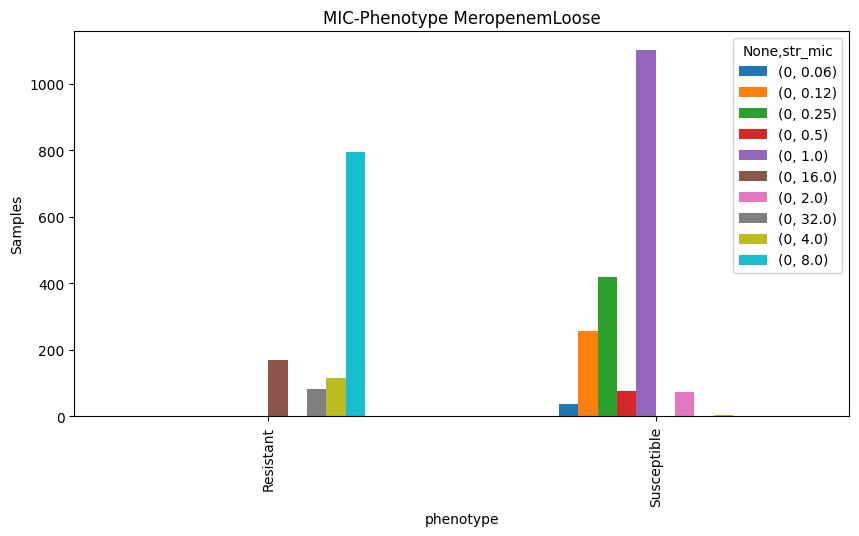

In [6]:
summary = pd.DataFrame(metadata.groupby(['phenotype','str_mic']).size())
plt.figure()
summary.unstack().plot.bar(figsize=(10,5))
plt.title('MIC-Phenotype ' + data_label)
plt.ylabel("Samples")
plt.show()


### Clasificación

Se obtienen datos de entrenamiento y prueba

In [42]:
X_tr = tfidf_rf

X_train, y_train, __, __, X_test, y_test, class_w, __ = split_stratified_into_train_val_test(X_tr, y_cat, .80, 0, .20, 
                                                                                                std=False, two_subsets=True, random_state=42)
# para formar la variable de respuesta del problema de regresión, se pueden elegir dos opciones de MIC:
# - el 'mic' original, posiblemente con más valores diferentes que los considerados en las categorias ordinales (se reagruparon los valores poco frecuentes)
# - el recategorizado 'mic_recat', donde se reagruparon los valores poco frecuentes de concentración
y_train_reg = metadata_tr.loc[X_train.index]['mic_recat']
y_test_reg = metadata_tr.loc[X_test.index]['mic_recat']

#### Visualizaciones de baja dimensión

In [11]:
lab = 'str_mic'
lab2 = 'phenotype'
embedding = amr_train_lsa
reduced_proj = pd.DataFrame({'x1': embedding.iloc[:,0], 'x2': embedding.iloc[:,1], 'label': metadata_tr[lab], 'label2': metadata_tr[lab2]})
fig = px.scatter(reduced_proj, x='x1', y='x2', hover_data='label2', color = 'label', title='reduced plot')
fig.update_layout(autosize=False, width=700, height=700)
fig.show()

In [12]:
embedding = amr_train_nmf
reduced_proj = pd.DataFrame({'x1': embedding.iloc[:,0], 'x2': embedding.iloc[:,1], 'label': metadata_tr[lab], 'label2': metadata_tr[lab2]})
fig = px.scatter(reduced_proj, x='x1', y='x2', hover_data='label2', color = 'label', title='reduced plot')
fig.update_layout(autosize=False, width=700, height=700)
fig.show()

In [16]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=25, n_components=3, min_dist=.8, metric='cosine')
#embedding = reducer.fit_transform(amr_train_lsa)
embedding = reducer.fit_transform(tfidf_train)

In [17]:
umap_proj = pd.DataFrame({'x1': embedding[:,0], 'x2': embedding[:,1], 'label': metadata_tr[lab], 'label2': metadata_tr[lab2]})
fig = px.scatter(umap_proj, x='x1', y='x2', hover_data='label2', color = 'label', title='UMAP plot')
fig.update_layout(autosize=False, width=700, height=700)
fig.show()

#### Baselines y clasificación ordinal

In [10]:
# linear model
from sklearn.linear_model import LinearRegression 

# CART
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

# Boosting
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

# Bagging
from sklearn.ensemble import BaggingClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

Baselines

In [13]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_reg)
y_pred = linear_reg.predict(X_test)
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = root_mean_squared_error(y_test_reg, y_pred)
print('MAE: ', mae, '. RMSE: ',rmse)

MAE:  3.290367884268766 . RMSE:  5.30965853640071


In [14]:
cart_reg = DecisionTreeRegressor().fit(X_train, y_train_reg)
y_pred = cart_reg.predict(X_test)
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = root_mean_squared_error(y_test_reg, y_pred)
print('MAE: ', mae, '. RMSE: ',rmse)

MAE:  2.600446570972887 . RMSE:  6.503712251187932


## Regresión logística ordinal

In [15]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1, 2, 3, 4, 5, 10, 15, 20, 30],
    'clf__penalty': ['l1', 'l2', 'elasticnet']
}
# Crear instancia del clasificador con Logistic Regression
LR = LogisticRegression(max_iter=5000, solver='saga')
# Crear instancia de OrdinalClassifier con Logistic Regression como clasificador base
ordinal_clf = OrdinalClassifier(LR)
cv = 5
best_params, best_score = search_params_ordinal(ordinal_clf, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'clf__C': 20, 'clf__penalty': 'l1'}
Mejor puntuación: 0.6493753528798976


In [16]:
# Realiza K-FOLD CV para obtener estadísticas de desempeño
LR = LogisticRegression(max_iter=5000, C = best_params['clf__C'], penalty = best_params['clf__penalty'], solver = 'saga')
# Crear una nueva instancia de OrdinalClassifier con los parámetros óptimos
best_model = OrdinalClassifier(LR)

n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = ordinal_clas_stat2(best_model, X_train, y_train, rand_state = 42, n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

NameError: name 'cv_scores' is not defined

In [18]:
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")


MAE: 1.060 +/- 0.072
RMSE: 2.106 +/- 0.056


MAE:  1.132 
RMSE:  2.253
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.46      0.41      0.43        51
           2       0.60      0.69      0.64        84
           3       0.00      0.00      0.00        15
           4       0.71      0.86      0.77       221
           5       0.52      0.47      0.49        34
           6       0.00      0.00      0.00        15
           7       0.20      0.12      0.15        17
           8       1.00      0.12      0.22        24
           9       0.73      0.74      0.73       159

    accuracy                           0.65       627
   macro avg       0.42      0.34      0.34       627
weighted avg       0.62      0.65      0.62       627



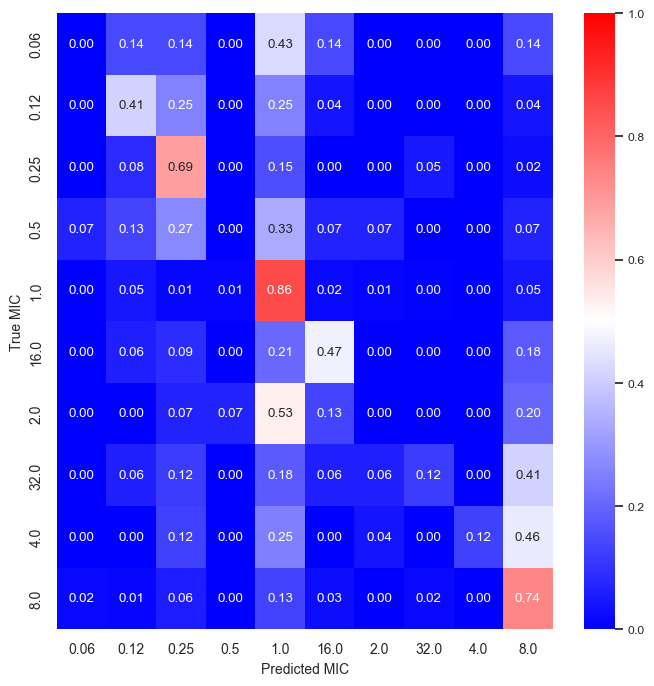

In [19]:
# entrena el modelo con los parámetros óptimos y hace la predicción en los datos de test
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## CART ordinal

In [24]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__ccp_alpha': [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
}
# Crear instancia del clasificador
DT = DecisionTreeClassifier()
# Crear instancia de OrdinalClassifier 
ordinal_clf = OrdinalClassifier(DT)
cv = 5
best_params, best_score = search_params_ordinal(ordinal_clf, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'clf__ccp_alpha': 0.005, 'clf__criterion': 'entropy', 'clf__max_features': 'sqrt'}
Mejor puntuación: 0.5656122018910386


In [25]:
# Crear una nueva instancia del clasificador ordinal
DT = DecisionTreeClassifier(ccp_alpha = best_params['clf__ccp_alpha'],
                            criterion = best_params['clf__criterion'],
                            max_features = best_params['clf__max_features'])

# Crear una nueva instancia de OrdinalClassifier con LogisticRegression actualizado
best_model = OrdinalClassifier(DT)

n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = ordinal_clas_stat2(best_model, X_train, y_train, rand_state = 42, n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

MAE: 1.245 +/- 0.078
RMSE: 2.222 +/- 0.106


MAE:  1.402 
RMSE:  2.398
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.42      0.10      0.16        51
           2       0.52      0.55      0.53        84
           3       0.02      0.07      0.04        15
           4       0.70      0.77      0.73       221
           5       0.18      0.38      0.24        34
           6       0.05      0.07      0.05        15
           7       0.09      0.12      0.10        17
           8       0.07      0.04      0.05        24
           9       0.77      0.54      0.63       159

    accuracy                           0.52       627
   macro avg       0.28      0.26      0.25       627
weighted avg       0.56      0.52      0.52       627



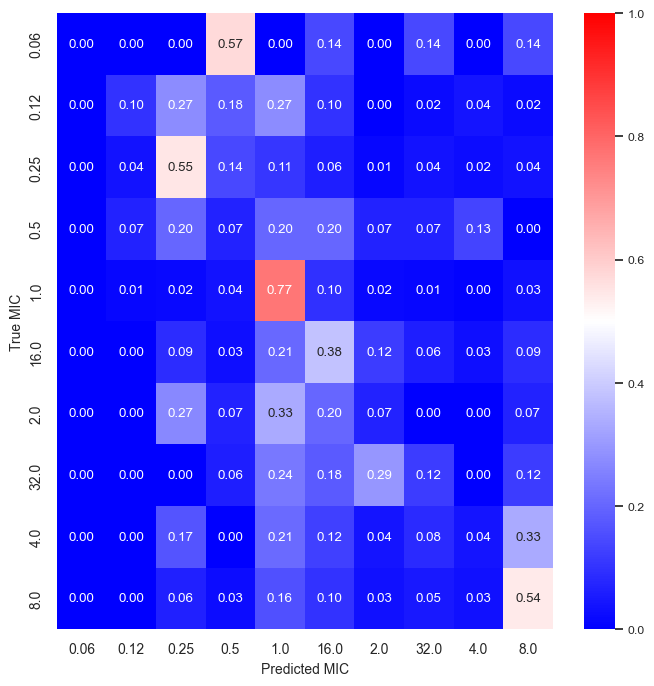

In [27]:
# entrena el modelo con los parámetros óptimos y hace la predicción en los datos de test
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## Random Forests ordinal

In [28]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__class_weight': ['balanced', 'balanced_subsample'],
    'clf__ccp_alpha': [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    'clf__max_features': ['sqrt', 'log2']
}

# Crear instancia del clasificador
RF = RandomForestClassifier()
# Crear instancia de OrdinalClassifier 
ordinal_clf = OrdinalClassifier(RF)
cv = 5
best_params, best_score = search_params_ordinal(ordinal_clf, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'clf__ccp_alpha': 0.001, 'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'entropy', 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}
Mejor puntuación: 0.6996310168507607


In [29]:
# Crear una nueva instancia del clasificador ordinal
RF = RandomForestClassifier(n_estimators = best_params['clf__n_estimators'],
                            criterion = best_params['clf__criterion'],
                            class_weight = best_params['clf__class_weight'],
                            ccp_alpha = best_params['clf__ccp_alpha'],
                            max_features = best_params['clf__max_features'])

# Crear una nueva instancia de OrdinalClassifier con LogisticRegression actualizado
best_model = OrdinalClassifier(RF)

n_repeats = 10
mean_mae, mean_rmse, std_mae, std_rmse = ordinal_clas_stat2(best_model, X_train, y_train, rand_state = 42, n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print(f"MAE: {mean_mae:.3f} +/- {std_mae:.3f}")
print(f"RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")

MAE: 1.012 +/- 0.048
RMSE: 2.171 +/- 0.056


MAE:  0.97 
RMSE:  2.125
              precision    recall  f1-score   support

           0       0.17      0.14      0.15         7
           1       0.70      0.45      0.55        51
           2       0.64      0.77      0.70        84
           3       0.14      0.13      0.14        15
           4       0.80      0.88      0.84       221
           5       0.65      0.50      0.57        34
           6       0.14      0.07      0.09        15
           7       0.73      0.47      0.57        17
           8       0.33      0.12      0.18        24
           9       0.73      0.81      0.76       159

    accuracy                           0.70       627
   macro avg       0.50      0.43      0.45       627
weighted avg       0.68      0.70      0.69       627



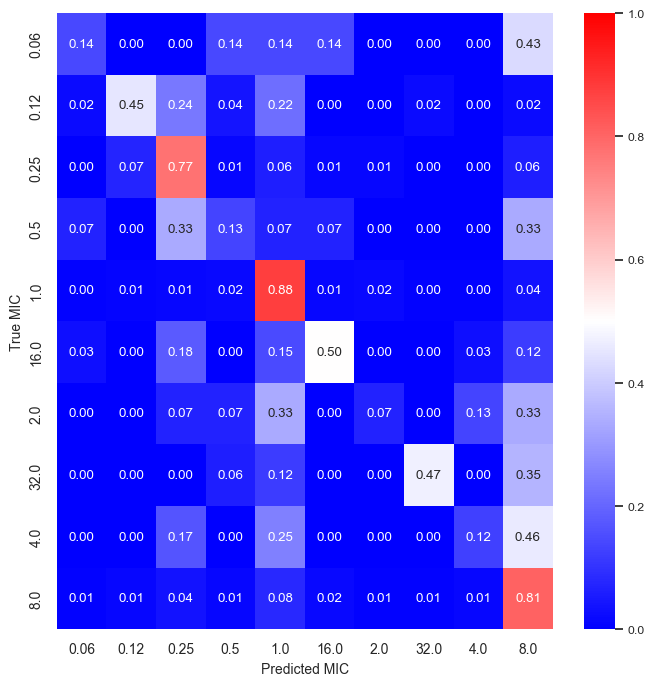

In [33]:
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## Red neuronal ordinal

In [43]:
from camda_functions import ordinal_encoding_nn, prediction2label_nn, cross_val_metrics_nn

X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

# recodificar la variable de respuesta con un encoding ordinal
n_clas = len(le.classes_)
n_var = X_train_np.shape[1]
y_tr_oc = ordinal_encoding_nn(y_train, n_clas)
y_te_oc = ordinal_encoding_nn(y_test, n_clas)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import activations

# Crear una instancia del modelo
model = Sequential()
#model.add(Dropout(0.2, input_shape = (n_var,)))
#model.add(Dense(80, activation='relu'))
model.add(Dense(80, input_dim=n_var, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dense(n_clas, activation='sigmoid')) 

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [48]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [33]:
# Cross validation
cv = 5
mae_mean, mae_std, rmse_mean, rmse_std = cross_val_metrics_nn(model, X_train_np, y_tr_oc, cv)
# Imprimir los resultados
print(f"MAE: {mae_mean} +/- {mae_std}")
print(f"RMSE: {rmse_mean} +/- {rmse_std}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
MAE: 0.9424775946115735 +/- 0.13046102721873326
RMSE: 1.8308275493064745 +/- 0.15337652307534919


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
MAE:  0.923 
RMSE:  1.844
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.80      0.24      0.36        51
           2       0.57      0.76      0.65        84
           3       0.06      0.13      0.09        15
           4       0.79      0.83      0.81       221
           5       0.40      0.53      0.46        34
           6       0.00      0.00      0.00        15
           7       0.26      0.53      0.35        17
           8       0.00      0.00      0.00        24
           9       0.80      0.71      0.75       159

    accuracy                           0.64       627
   macro avg       0.37      0.37      0.35       627
weighted avg       0.65      0.64      0.63       627



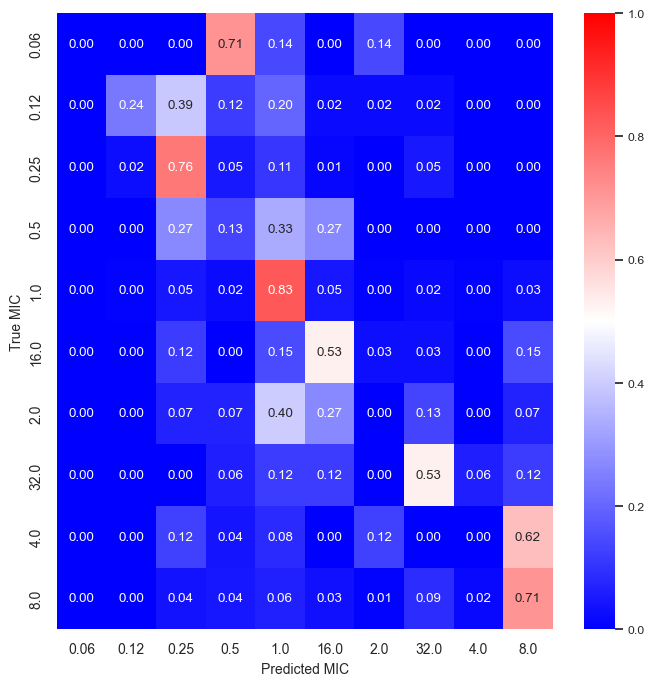

In [36]:
# Train the model
model.fit(X_train_np, y_tr_oc, epochs=50, batch_size=16, validation_data=(X_test_np, y_te_oc), verbose=False)
y_hat = prediction2label_nn(model.predict(X_test))
results_report(y_test, y_hat, le)